#  3 对抗搜索

## 零和游戏

一些游戏可以等价于: 有个全局分数 $v$, 甲的目标是使 $v$ 尽量大, 乙的目标是使 $v$ 尽量小. 这样的游戏称为零和 (zero sum) 游戏.


<br>

例如五子棋, 若甲胜则使 $v=+\inf$, 若乙胜则使 $v=-\inf$, (若平局则 $v=0$). 则甲乙双方的目标均等价于追求胜利. 所以五子棋可以视为零和游戏.

## 极小极大搜索 (Minimax Search)


在如上所述的**零和游戏**中, **把 AI 视为甲**, 则 AI 每一步的目标是最大化 $v$, 其对手每一步的目标是最小化 $v$. 

为此可以构建一个树型的数据结构, 分为两种节点: 极大节点和极小节点. 每个节点的后继节点是选择各个行动的结果.

<br>

极大节点是甲 (AI) 准备行动的回合, 极小节点是乙行动的回合. 一个极大节点的值是其后继节点的值的最大值, 极小节点反之. 

这样, 每个节点通过 DFS 不停地计算值, 直至终止节点 (terminal / leaf node).

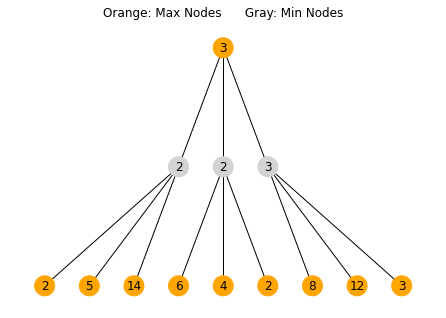

In [30]:
import networkx as nx
from matplotlib import pyplot as plt
G = nx.Graph()
[G.add_node(i, layer = 2 if i == 0 else (1 if i < 4 else 0)) for i in range(13)]
[G.add_edge(a, b) for a, b in [(0, i) for i in range(1,4)]]
for j in range(1, 4):
    [G.add_edge(j, (j*3 + 1 + i)) for i in range(3)]

pos = nx.multipartite_layout(G, subset_key = 'layer', align = 'horizontal')
nx.draw(G, pos, node_size = 400, node_color = ['orange'] + ['lightgray'] * 3 + ['orange'] * 9, 
        labels = dict(zip(range(13), [3,3,2,2,3,12,8,2,4,6,14,5,2])))
plt.title('Orange: Max Nodes      Gray: Min Nodes')
plt.show()

In [19]:
# 井字棋 -- 用 Minimax
n = 3
class TicTacToe():
    def __init__(self, state):
        # 0: player AI, 1: opponent, 2: empty
        self.state = [[2 for i in range(n)] for j in range(n)] if state is None else state
        self.turn = sum(sum(self.state[i][j] != 2 for i in range(n)) for j in range(n))
    
    def max_node(self):
        t = self.terminate(1)
        if t is not None: return (1, None) if t == 0 else ((-1, None) if t == 1 else (0, None))
        v, a = -2147483647, None # initialize
        for m in self.next_moves():
            self.turn += 1
            self.state[m[0]][m[1]] = 0 # attempt a move
            v2, a2 = self.min_node()
            self.state[m[0]][m[1]] = 2 # cancel the move
            self.turn -= 1
            if v2 > v:
                v, a = v2, m
        return v, a

    def min_node(self):
        t = self.terminate(0)
        if t is not None: return (1, None) if t == 0 else ((-1, None) if t == 1 else (0, None))
        v, a = 2147483647, None # initialize
        for m in self.next_moves():
            self.turn += 1
            self.state[m[0]][m[1]] = 1 # attempt a move
            v2, a2 = self.max_node()
            self.state[m[0]][m[1]] = 2 # cancel the move
            self.turn -= 1
            if v2 < v:
                v, a = v2, m
        return v, a

    def next_moves(self):
        moves = []
        for i in range(n):
            for j in range(n):
                if self.state[i][j] == 2: # empty
                    moves.append((i, j))
        return moves

    def terminate(self, c): 
        """Return the player that wins. Return None if not terminate. Return 2 if tie."""
        s = self.state
        for i in range(n): 
            if all(s[i][j] == c for j in range(n)): return c
            if all(s[j][i] == c for j in range(n)): return c
        if all(s[i][i] == c for i in range(n)): return c
        if all(s[i][n-1-i] == c for i in range(n)): return c
        if self.turn == n * n: return 2 # tie
        return None

In [45]:
from copy import deepcopy
state = [[2,2,2],[2,2,2],[2,2,2]]
turn, states = 0, [deepcopy(state)]
ttt = TicTacToe(state)
while ttt.terminate() is not None:
    if turn == 0:
        TicTacToe(state).max_node()

(0, (0, 1))

### 截断搜索

很多时候, 不可能搜索地完. 如果达到一定深度需要停止搜索, 立即返回一个 (估计的) 效用值.

## Alpha-Beta 剪枝
